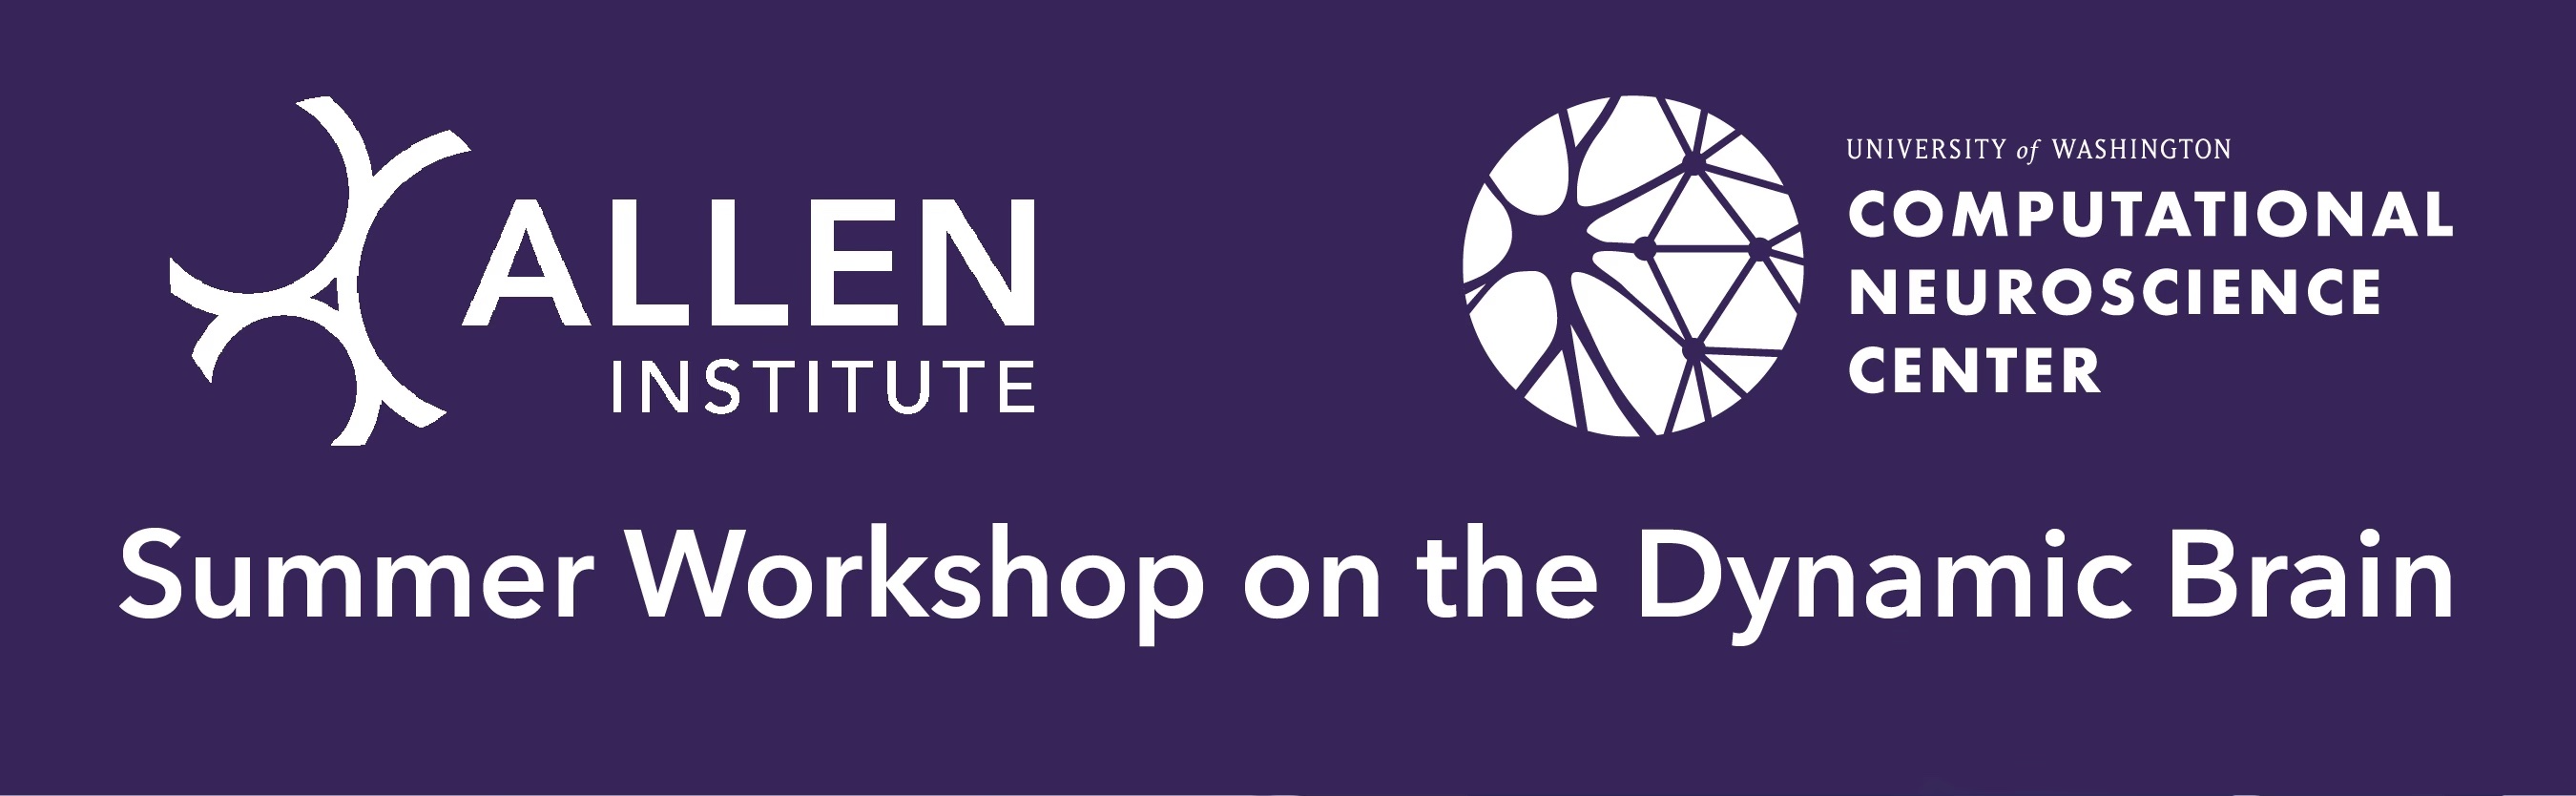

<h1 align="center">Day 1 Workshop 2: Science Quest</h1>  
<h2 align="center"> How do neuron interactions change after learning? </h4>   
<h2 align="center"> SWDB 2025</h2> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h2>Goal</h2>
    
In this workshop, we will use our data access skills and dataset knowledge to ask a specific question: 

<b>How do neuron interactions change after learning?</b>
   
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
How should we go about addressing this question? 
    
#### <b> Step 1: </b>Which datasets have we learned about that would be useful to analyze to address this question? 
    
We will want a dataset with a behavior task where the mouse has to learn something, and we will want there to be a period of time before and after learning that we can use to compare activity to see if it changes. 
    
Let's look at our [SWDB Dataset Features Spreadsheet](https://docs.google.com/spreadsheets/d/1zwqS97x81jEVUUMTLLtlk6NMMR2C7DhY9nJDB2BLvBE/edit?usp=sharing) and find a dataset with a behavior task and spontaneous activity periods pre and post task learning. 
    
We can use... the BCI learning dataset! 
    
<b>Why use this dataset?</b> In this dataset, mice learn to control the activity of a specific neuron in order to receive rewards using a brain computer interface (BCI) paradigm. The activity of the conditioned neuron is read out in real time and is linked to the movement of a reward spot. Over a few trials, the activity of the conditioned neuron becomes coupled to the movement of the spout and the mouse "learns" to activate that neuron to move the spout towards then to get rewards. In contrast to other behavior tasks, this task enables us to study how learning of a single neuron can affect other cells in the network. See below for additional details of this dataset. 
    
#### <b> Step 2: </b>What analysis method can we use to address this question? 
    
One simple way to see if neurons could be interacting is to quantify how correlated their activity patterns are. If neurons are consistently co-active, they are likely to be connected or receive shared input as part of an interacting circuit. 
        
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Let's use our new data access skills to load the BCI data and compare neuron activity correlations during the spontaneous periods before and after a mouse learns the BCI task!

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2>Outline:</h2>
    
<h4>Part 1: Accessing the BCI data</h4> 
    - Metadata table & pynwb

    
<h4>Part 2: What are the conditions in this dataset? </h4>
    - Epochs & Trials

<h4>Part 3: Quantifying activity correlations before and after BCI learning</h4>
    - Cell activity traces, selecting epochs of interest, computing correlations

<h4>Part 4: Do correlations depend on distance between neurons?</h4>
    - Segmented ROI masks and spatial relationships
<h4>   </h4>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>BCI dataset overview </h2> 
    
**Overview:** In this notebook, we will analyze changes in neuronal correlations before and after learning using a dataset from the [Credit Assignment During Learning](https://www.allenneuraldynamics.org/projects/credit-assignment-during-learning) 
project at the Allen Institute for Neural Dynamics. This dataset provides a unique window 
into how cortical circuits adapt as mice learn to volitionally control a brain-computer interface (BCI) 
using single neurons in motor cortex. This tutorial focuses on data access, session structure (photostimulation and task periods), correlation structure among populations of neurons, and relating correlations to anatomical distance between cells.  

 **Experiment:**
 This experiment was designed to test competing models of learning rules—such as Hebbian learning, 
 long-range input modulation, and biologically plausible approximations of error backpropagation—by 
 directly measuring changes in neural activity and inferred connectivity during learning. 
 The core task involved a closed-loop BCI paradigm in which a single neuron’s activity controlled 
 a reward mechanism. Because the mapping from activity to behavior was fully defined by the experimenter,
  this paradigm enables ground-truth labeling of neurons as behaviorally causal (e.g., the conditioned neuron) versus merely correlated.
    
To probe learning-related circuit changes, cellular-resolution two-photon photostimulation
 was used to perturb neurons before and after learning. By analyzing evoked responses, 
 researchers could infer the presence and strength of functional connections. 
 Learning-induced changes in connectivity were then compared to predictions 
 from recurrent neural network models trained with different plasticity rules, 
 enabling discrimination between competing learning algorithms.
    
**Dataset:** 
Neural activity was recorded from layer 2/3 excitatory neurons in the primary motor cortex 
of head-fixed mice using two-photon calcium imaging. Imaging was performed over multiple days
 as each animal learned and performed a BCI task. Each day, a new conditioned neuron (CN) was selected, 
 the activity of this neuron was mapped in real-time to the position of a motorized reward port. 
 To receive water rewards, mice had to learn to increase the activity of the conditioned neuron to move the port into reach.

In addition to the BCI task, the dataset includes photostimulation blocks in which individual or 
groups of neurons were optogenetically stimulated to assess their causal influence on the surrounding network. 
These connection mapping sessions were repeated daily to measure how connectivity changed as learning progressed.
 Imaging data were preprocessed using Suite2p and include motion-corrected fluorescence traces, 
 extracted ROIs, inferred spiking events, and stimulus-aligned behavioral metadata. 
 All data are registered across days to track the same neurons longitudinally.




<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Import packages and load data

In [70]:
# General imports 
import os 
import re
import numpy as np
import pandas as pd
from pathlib import Path
import scipy.stats as stats 
from skimage import measure
import matplotlib.pyplot as plt

# Pynwb imports
from hdmf_zarr import NWBZarrIO
from nwbwidgets import nwb2widget

In [71]:
# set data path
import sys
import platform
from os.path import join as pjoin

platstring = platform.platform()
system = platform.system()
if system == "Darwin":
    # macOS
    data_dir = "/Volumes/Brain2025/"
elif system == "Windows":
    # Windows (replace with the drive letter of USB drive)
    data_dir = "E:/"
elif "amzn" in platstring:
    # then on CodeOcean
    data_dir = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_dir = "/media/$USERNAME/Brain2025/"
    
print('data directory set to', data_dir)

data directory set to /data/


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Part 1: Accessing the BCI data</h2>   

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Metadata

The *bci_metadata.csv* file in the */data/metadata/* folder contains relevant information about the experimental session and the subject. 

| Column    | Description |
| -------- | ------- |
| id | data asset id |
| name | filename of data asset (raw) |
| subject_id| numerical id for animal subject  |
| session_time |  experiment date (%Y-%m-%d %H:%M:%S)   |
| session_type   |  experiment identifier  |
| genotype  | subject genotype   |
| virus   | injected virus type  |
| ophys_fov   | field of view identifier  |
| session_number    | behavior training session number   |

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** Load the metadata csv file as a pandas dataframe. What are the column values? 

</div>

In [72]:
metadata = pd.read_csv(os.path.join(data_dir, 'metadata', 'bci_metadata.csv'))
metadata.head()

,project_name,session_type,_id,name,subject_id,genotype,virus,date_of_birth,sex,modality,session_date,age,session_time,targeted_structure,ophys_fov,session_number
0,Brain Computer Interface,BCI single neuron stim,03f1b82e-4494-46bc-a959-50c4b14d13da,single-plane-ophys_731015_2025-01-28_17-40-57_...,731015,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,2024-03-14,Female,Planar optical physiology,2025-01-28,320,17:40:57.996000,Primary Motor Cortex,FOV_04,22.0
1,Brain Computer Interface,BCI single neuron stim,b28d6321-1b1b-4110-87fb-0e19325c1dfe,single-plane-ophys_767715_2025-02-17_17-41-50_...,767715,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,2024-09-15,Female,Planar optical physiology,2025-02-17,155,17:41:50.758000,Primary Motor Cortex,FOV_03,8.0
2,Brain Computer Interface,BCI single neuron stim,580448b2-4b93-4477-b6ac-6e2972792fe0,single-plane-ophys_772414_2025-01-27_15-57-05_...,772414,Camk2a-tTA/wt;tetO-GCaMP6s/wt,pAAV-CaMKIIa-ChRmine-oScarlet-Kv2.1-WPRE - 7413,2024-10-15,Female,Planar optical physiology,2025-01-27,104,14:23:26.693000,Primary Motor Cortex,FOV_01,5.0
3,Brain Computer Interface,BCI single neuron stim,c1be8449-7bef-4967-88f5-6a6ffc29e5a3,single-plane-ophys_772414_2025-02-06_16-47-44_...,772414,Camk2a-tTA/wt;tetO-GCaMP6s/wt,pAAV-CaMKIIa-ChRmine-oScarlet-Kv2.1-WPRE - 7413,2024-10-15,Female,Planar optical physiology,2025-02-06,114,16:47:44.152999,Primary Motor Cortex,FOV_02,13.0
4,Brain Computer Interface,BCI single neuron stim,15b395c0-1caf-4be4-a212-a13b9a4d1dfc,single-plane-ophys_772414_2025-02-10_11-15-26_...,772414,Camk2a-tTA/wt;tetO-GCaMP6s/wt,pAAV-CaMKIIa-ChRmine-oScarlet-Kv2.1-WPRE - 7413,2024-10-15,Female,Planar optical physiology,2025-02-10,118,11:15:26.609999,Primary Motor Cortex,FOV_03,14.0


In [73]:
metadata.columns

Index(['project_name', 'session_type', '_id', 'name', 'subject_id', 'genotype',
       'virus', 'date_of_birth', 'sex', 'modality', 'session_date', 'age',
       'session_time', 'targeted_structure', 'ophys_fov', 'session_number'],
      dtype='object')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

What are the unique values for `genotype`? What aspects of the genotype might be useful for this experiment?

</div>

In [74]:
metadata.genotype.unique()

array(['Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-ICL-ChRmine-oScarlet-IRES2-tTA2-WPRE)-hyg/wt',
       'Camk2a-tTA/wt;tetO-GCaMP6s/wt',
       'Camk2a-tTA/wt;TetO-jGCaMP8s-01/wt'], dtype=object)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

How many sessions are there per mouse? 

</div>

In [75]:
metadata.value_counts(['subject_id'])

subject_id
731015        7
740369        7
754303        6
767715        6
772414        4
766719        3
Name: count, dtype: int64

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
#### Loading session data from an NWB file
    
Everything you need to analyze the data from one experimental session lives in the NWB file


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
        
First, let's select a mouse and session to look at


In [76]:
# Pick the first mouse
subject_ids = np.sort(metadata['subject_id'].unique())
subject_id = subject_ids[0]
print('Selected subject_id is', subject_id)

# Look at its metadata, sorted by 'session_number'
this_mouse_metadata = metadata[metadata['subject_id']==subject_id].sort_values(by='session_number')
this_mouse_metadata

Selected subject_id is 731015


,project_name,session_type,_id,name,subject_id,genotype,virus,date_of_birth,sex,modality,session_date,age,session_time,targeted_structure,ophys_fov,session_number
26,Brain Computer Interface,BCI single neuron stim,b8827d25-495f-46a8-9f33-ffb24da527a5,single-plane-ophys_731015_2025-01-10_18-06-31_...,731015,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,2024-03-14,Female,Planar optical physiology,2025-01-10,302,16:46:51.981999,Primary Motor Cortex,FOV_04; FOV_04,18.0
27,Brain Computer Interface,BCI single neuron stim,85ff1fdd-3415-46a7-af9a-c77385a68463,single-plane-ophys_731015_2025-01-13_20-09-20_...,731015,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,2024-03-14,Female,Planar optical physiology,2025-01-13,305,18:53:03.001999,Primary Motor Cortex,FOV_04,19.0
28,Brain Computer Interface,BCI single neuron stim,127a3e78-729c-4df7-bf34-1b9308939587,single-plane-ophys_731015_2025-01-24_20-00-44_...,731015,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,2024-03-14,Female,Planar optical physiology,2025-01-24,316,18:41:22.550000,Primary Motor Cortex,FOV_04,20.0
0,Brain Computer Interface,BCI single neuron stim,03f1b82e-4494-46bc-a959-50c4b14d13da,single-plane-ophys_731015_2025-01-28_17-40-57_...,731015,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,2024-03-14,Female,Planar optical physiology,2025-01-28,320,17:40:57.996000,Primary Motor Cortex,FOV_04,22.0
29,Brain Computer Interface,BCI single neuron stim,265c6a41-2783-4edd-b707-e4feaa77aad2,single-plane-ophys_731015_2025-01-28_17-40-57_...,731015,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,2024-03-14,Female,Planar optical physiology,2025-01-28,320,17:40:57.996000,Primary Motor Cortex,FOV_04,22.0
6,Brain Computer Interface,BCI single neuron stim,0162d41c-613c-4215-b0aa-9690f85a9fda,single-plane-ophys_731015_2025-01-28_18-56-35_...,731015,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,2024-03-14,Female,Planar optical physiology,2025-01-28,320,17:40:57.996000,Primary Motor Cortex,FOV_04,22.0
5,Brain Computer Interface,BCI single neuron stim,b9a4c361-66b0-4cd5-9392-75d116ef3385,single-plane-ophys_731015_2025-01-31_20-37-19_...,731015,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,2024-03-14,Female,Planar optical physiology,2025-01-31,323,20:37:19.623000,Primary Motor Cortex,FOV_04,23.0


In [77]:
# Let's pick the last session for this mouse
session_date = this_mouse_metadata.session_date.values[-1]
print('Selected session date is', session_date)

Selected session date is 2025-01-31


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Find the session folder in */data/brain-computer-interface/* then get the NWB file path

In [78]:
# Get the directory for this dataset
bci_data_dir = os.path.join(data_dir, 'brain-computer-interface')
print(bci_data_dir)

/data/brain-computer-interface


In [79]:
# Iterate through all the sessions in the dataset folder and find the one that has our mouse's subject_id and session date in the folder name
session_folder = [folder for folder in os.listdir(bci_data_dir) if str(subject_id) in folder and str(session_date) in folder][0]
print(session_folder)

single-plane-ophys_731015_2025-01-31_20-37-19_processed_2025-08-06_05-37-58


In [80]:
# Get the data folder for this session
session_dir = os.path.join(bci_data_dir, session_folder)
print(session_dir)

/data/brain-computer-interface/single-plane-ophys_731015_2025-01-31_20-37-19_processed_2025-08-06_05-37-58


In [81]:
# Now find the NWB file and set the path to load it
nwb_file = [file for file in os.listdir(session_dir) if 'nwb' in file][0]
nwb_path = os.path.join(session_dir, nwb_file)
print(nwb_path)

/data/brain-computer-interface/single-plane-ophys_731015_2025-01-31_20-37-19_processed_2025-08-06_05-37-58/single-plane-ophys_731015_2025-01-31_20-37-19_behavior_nwb


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

Load the NWB file for this session and examine its contents
    
</div>

In [82]:
with NWBZarrIO(str(nwb_path), 'r') as io:
    nwbfile = io.read()
    print('Loaded NWB file from:', nwb_path)

/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Loaded NWB file from: /data/brain-computer-interface/single-plane-ophys_731015_2025-01-31_20-37-19_processed_2025-08-06_05-37-58/single-plane-ophys_731015_2025-01-31_20-37-19_behavior_nwb


In [83]:
nwbfile

root pynwb.file.NWBFile at 0x140716514323536
Fields:
  devices: {
    442_Bergamo_2p_photostim <class 'pynwb.device.Device'>
  }
  epochs: epochs <class 'pynwb.epoch.TimeIntervals'>
  file_create_date: [datetime.datetime(2025, 8, 6, 0, 44, 16, 738660, tzinfo=tzutc())]
  identifier: abe650ab-452c-4053-beb2-3e166e984c3d
  imaging_planes: {
    processed <class 'pynwb.ophys.ImagingPlane'>
  }
  institution: Allen Institute for Neural Dynamics
  intervals: {
    epochs <class 'pynwb.epoch.TimeIntervals'>
  }
  processing: {
    processed <class 'pynwb.base.ProcessingModule'>
  }
  session_description: NWB file generated by AIND pipeline
  session_id: single-plane-ophys_731015_2025-01-31_20-37-19
  session_start_time: 2025-01-31 20:37:19-08:00
  stimulus: {
    PhotostimTrials <class 'hdmf.common.table.DynamicTable'>,
    Trials <class 'hdmf.common.table.DynamicTable'>
  }
  subject: subject pynwb.file.Subject at 0x140716532781056
Fields:
  age: P323D
  age__reference: birth
  date_of_birth: 2024-03-14 00:00:00-07:53
  genotype: Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-ICL-ChRmine-oScarlet-IRES2-tTA2-WPRE)-hyg/wt
  sex: F
  species: Mus musculus
  subject_id: 731015

  timestamps_reference_time: 2025-01-31 20:37:19-08:00

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### NWB files

As you'll recall from the previous workshop, NWB files are a standardized file format for systems neuroscience experiments. They are formatted similarly to hdf5 containers, with data stored using a hierarchical format. 
    
`nwb2widget` creates an interactive widget to easily explore the hierarchical contents of the NWB file. The widget can also render interactive data plots (e.g. calcium activity traces, image segmentation masks). 

In [84]:
nwb2widget(nwbfile) 


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Part 2: What are the conditions in this dataset? </h2>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Epoch Table 
    
The epochs table contains the start and stop times / frames for each experimental epoch. This tells you what types of conditions are in the experiment. 
    
The start and stop frames can be used to index into the 2-photon timeseries, since they are temporally aligned. 


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

Load the `epochs` table from the *<b>intervals</b>* container of the NWB file. 
    
Use the `to_dataframe()` method to put the data into a pandas table and save it to a variable named `epoch_table`. 
    
What epochs are present?

</div>

In [119]:
epoch_table = nwbfile.intervals["epochs"].to_dataframe()
epoch_table

,stimulus_name,start_frame,stop_frame,start_time,stop_time
id,,,,,
0,photostim,0,84794,0.000000,1455.356193
1,spont,84795,90794,1455.373356,1558.336795
2,spont_01,90795,98594,1558.353958,1692.211577
3,BCI,98595,160009,1692.228741,2746.303855
4,spont_post,160010,175538,2746.321018,3012.834816
5,photostim_post,175539,249369,3012.851979,4280.028285


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Overlay epochs with cell activity traces  
    
First load the `dff_traces` from the *<b>processing</b>* container of the NWB file. 
    
What is the shape of the data?
        
</div>

In [85]:
dff_traces = nwbfile.processing["processed"].data_interfaces["dff"].roi_response_series["dff"].data
print('dff shape (nframes, nrois):',np.shape(dff_traces))


dff shape (nframes, nrois): (249370, 1736)


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
What is the imaging frame rate? 

</div>

In [86]:
frame_rate = nwbfile.imaging_planes["processed"].imaging_rate
print('Frame Rate:', frame_rate)

Frame Rate: 58.2634


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now plot the dF/F trace for ROI = 100 with the stimulus epochs overlaid in color. Does it's activity change across epochs?
        
</div>

/tmp/ipykernel_17100/2577709309.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Paired')


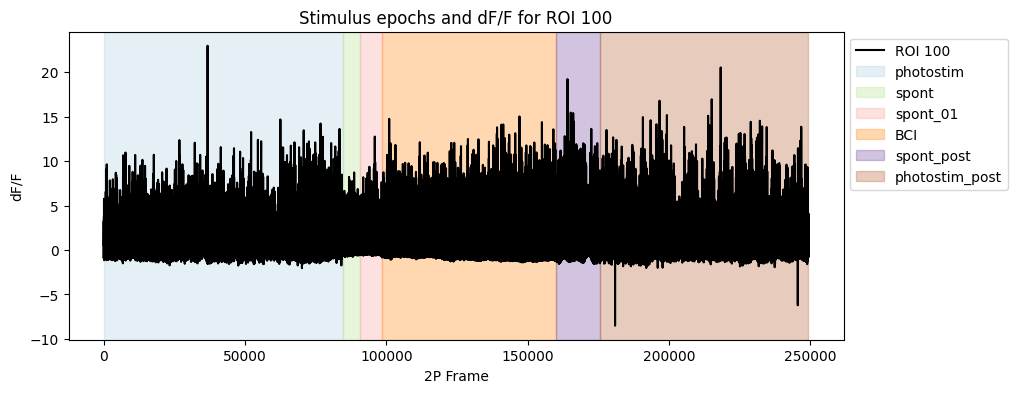

In [87]:
# Pick an ROI
ROI = 100

# Plot dff trace for selected ROI 
plt.rcParams["figure.figsize"] = (10, 4)
plt.plot(dff_traces[:, ROI], label=f'ROI {ROI}', color='black')

# Add shaded regions for stimulus epochs 
epoch_table = nwbfile.intervals["epochs"].to_dataframe()
stimulus_names = epoch_table.stimulus_name.unique()

import matplotlib.cm as cm
colors = cm.get_cmap('Paired')
colors = colors(np.linspace(0, 1, len(stimulus_names)))

                
for c, stimulus_name in enumerate(stimulus_names):
    stim_epoch = epoch_table[epoch_table.stimulus_name==stimulus_name]
    for j in range(len(stim_epoch)):
        plt.axvspan(xmin=stim_epoch.start_frame.iloc[j], xmax=stim_epoch.stop_frame.iloc[j], color=colors[c], alpha=0.3, label=stimulus_name)

plt.ylabel('dF/F')
plt.xlabel('2P Frame')
plt.title('Stimulus epochs and dF/F for ROI '+str(ROI))
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Trials tables
    
Trials tables tell you what happened in each epoch. They can be found in the *<b>stimulus</b>* container of the NWB file. 
 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

What types of trials tables are available? Check the keys of the *<b>stimulus</b>* container.
    
Does every epoch have a corresponding stimulus table? 

</div>

In [120]:
# These are the available trials tables
nwbfile.stimulus.keys()

dict_keys(['PhotostimTrials', 'Trials'])

In [121]:
# Check the epoch table - which epochs have trials? 
epoch_table

,stimulus_name,start_frame,stop_frame,start_time,stop_time
id,,,,,
0,photostim,0,84794,0.000000,1455.356193
1,spont,84795,90794,1455.373356,1558.336795
2,spont_01,90795,98594,1558.353958,1692.211577
3,BCI,98595,160009,1692.228741,2746.303855
4,spont_post,160010,175538,2746.321018,3012.834816
5,photostim_post,175539,249369,3012.851979,4280.028285


Note that the names of the trials tables might not always match exactly to the epoch names. Here we have to infer that the `Trials` key refers to the BCI epoch because all the other epochs are either photostim (which has a `PhotostimTrials` table already) or spontaneous epochs, which dont have any stimuli or trials. 


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Optogenetic photostimulation trials
    
The `PhotostimTrials` table contains information about each 2p optogenetic stimulation trial. Optogenetic stimulation is used in this experiment to probe connectivity between neurons. In each trial, one neuron is stimulated, and all other neurons are recorded. Neurons with short latency responses after the optostim can be considered to be connected. 
    
Here is a description of the columns of this table:

| Column    | Description |
| -------- | ------- |
| start_time  | stimulus start (s)  |
| stop_time | stimulus end (s)   |
| start_frame | stimulus start (frame)     |
| stop_frame    | stimulus end (frame)  |
| tiff_file   | data source file name  |
| stimulus_name    | stimulus name   |
| laser_x    | x coordinate of stimulated neuron (pixel)   |
| laser_y    | y coordinate of stimulated neuron (pixel)  |
| power    | stimulus intensity (mW)  |
| duration    | trial duration (s)  |
| stimulus_function    | stimulus template   |
| group_index    | identity of stimulated neuron(s)   |
| closest_roi    | index in dff that corresponds to the photostimulated neuron   |


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    
Load the `PhotostimTrials` table from the *<b>stimulus</b>* container and turn it into a dataframe. 
    
What stimuli are delivered during the photostim epoch? 

</div>

In [88]:
photostim = nwbfile.stimulus["PhotostimTrials"].to_dataframe()
photostim.head()


,start_time,stop_time,start_frame,stop_frame,tiff_file,stimulus_name,laser_x,laser_y,power,duration,stimulus_function,group_index,closest_roi
id,,,,,,,,,,,,,
0,0.000000,0.617884,0,36,spont_slm_00001.tif,photostim,241.425926,212.703704,4,0.092,scanimage.mroi.stimulusfunctions.logspiral,78,421
1,0.635047,1.218604,37,71,spont_slm_00002.tif,photostim,168.200000,149.975000,4,0.092,scanimage.mroi.stimulusfunctions.logspiral,55,355
2,1.235767,1.836487,72,107,spont_slm_00003.tif,photostim,165.013514,133.905405,4,0.092,scanimage.mroi.stimulusfunctions.logspiral,8,153
3,1.853651,2.454371,108,143,spont_slm_00004.tif,photostim,239.032258,40.870968,4,0.092,scanimage.mroi.stimulusfunctions.logspiral,65,1169
4,2.471534,3.089418,144,180,spont_slm_00005.tif,photostim,57.355556,112.800000,4,0.092,scanimage.mroi.stimulusfunctions.logspiral,15,85


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    
Check the unique values of the `stimulus_name` column of the `PhotostimTrials` table. 
    
Do they correspond to the stimulus names in the `epoch_table`?

</div>

In [89]:
# Stimuli in photostim trials table
photostim['stimulus_name'].unique()

array(['photostim', 'photostim_post'], dtype=object)

In [90]:
# Compare to epochs
epoch_table

,stimulus_name,start_frame,stop_frame,start_time,stop_time
id,,,,,
0,photostim,0,84794,0.000000,1455.356193
1,spont,84795,90794,1455.373356,1558.336795
2,spont_01,90795,98594,1558.353958,1692.211577
3,BCI,98595,160009,1692.228741,2746.303855
4,spont_post,160010,175538,2746.321018,3012.834816
5,photostim_post,175539,249369,3012.851979,4280.028285


There are two photostimulation epochs - one before and one after the BCI epoch.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### BCI behavior trials 
    
The behavior trials table contains information about what the mouse did during each trial, such as whether it licked or got a reward, and when in the trial these events happened. It also includes the ID of the conditioned neuron. 
    
Here is a description of the columns of this table:

| Column    | Description |
| -------- | ------- |
| start_time  | trial start (s)  |
| stop_time | trial end (s)   |
| go_cue |  time of go cue relative to start time (s)   |
| hit   |  boolean of whether trial was hit   |
| lick_l  | lick times (s)   |
| reward_time   | reward delivery time (s)   |
| threshold_crossing_times    | time when reward port crossed position threshold (s)   |
| zaber_steps_times   | position of reward port  |
| tiff_file    | data source file  |
| start_frame    | trial start (frame)  |
| stop_frame    | trial end (frame)  |
| conditioned_neuron_x    | coordinate for conditioned neuron (pixels)  |
| conditioned_neuron_y    | coordinate for conditioned neuron (pixels)  |
| closest_roi    | index in dff that corresponds to the photostimulated neuron  |


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    
**Exercise:** Load the `Trials` table from the *<b>stimulus</b>* container, turn it into a dataframe. 
    
What happens during the BCI task epoch? What information is provided for each trial?

</div>

,start_time,stop_time,go_cue,hit,lick_L,reward_time,threshold_crossing_times,zaber_step_times,tiff_file,start_frame,stop_frame,conditioned_neuron_x,conditioned_neuron_y,closest_roi
id,,,,,,,,,,,,,,
0,1692.228741,1704.020019,0.2359,True,"[1.7861, 1.9033, 2.0241, 2.1415, 2.2464, 2.375...",1.7861,1.7089,"[0.3535, 0.5054000000000001, 0.6074, 0.7184, 0...",neuron119_00001.tif,98595,99282,108.633333,51.666667,124
1,1704.037183,1708.722800,0.2359,True,"[1.0667, 1.2012, 1.3251000000000002, 1.4520000...",1.0667,1.0582,"[0.2869, 0.3589, 0.4188, 0.4969, 0.5359, 0.577...",neuron119_00002.tif,99283,99556,108.633333,51.666667,124
2,1708.739964,1714.060628,0.2359,True,"[0.7160000000000001, 0.8175, 0.9416, 1.0605, 1...",0.8175,0.7399,"[0.3182, 0.3502, 0.3822, 0.4142, 0.4462, 0.478...",neuron119_00003.tif,99557,99867,108.633333,51.666667,124
3,1714.077792,1718.488794,0.2359,True,"[1.0345, 1.1526, 1.2687000000000002, 1.392, 1....",1.0345,0.9577,"[0.4984, 0.5503, 0.5874, 0.6204000000000001, 0...",neuron119_00004.tif,99868,100125,108.633333,51.666667,124
4,1718.505957,1725.869070,0.2359,True,"[1.3371, 1.4519, 1.5667, 1.6952, 1.8063, 1.932...",1.3371,1.3072,"[0.8276, 0.8886000000000001, 0.9356, 0.9736, 1...",neuron119_00005.tif,100126,100555,108.633333,51.666667,124


Index(['start_time', 'stop_time', 'go_cue', 'hit', 'lick_L', 'reward_time',
       'threshold_crossing_times', 'zaber_step_times', 'tiff_file',
       'start_frame', 'stop_frame', 'conditioned_neuron_x',
       'conditioned_neuron_y', 'closest_roi'],
      dtype='object')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** What is the ROI ID of the conditioned neuron? 
    
Check the column descriptions provided above if you are unsure how to find it
    
</div>

#### Could the learning that happens during the BCI task epoch change the activity of the other neurons in the imaging plane? 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Part 3: Quantifying activity correlations before and after BCI learning</h2>
    - Cell activity traces, selecting time periods of interest, computing correlations
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We can quantify correlations during the spontaneous activity periods before and after the BCI task to see if cell interactions have changed due to learning. 
    
Let's use the <b>epochs</b> table to identify the `start_frame` and`stop_frame` for the spontaneous activity periods before and after the BCI task.

In [93]:
# Load the epochs table from the NWB file
epoch_table = nwbfile.intervals["epochs"].to_dataframe()
epoch_table

,stimulus_name,start_frame,stop_frame,start_time,stop_time
id,,,,,
0,photostim,0,84794,0.000000,1455.356193
1,spont,84795,90794,1455.373356,1558.336795
2,spont_01,90795,98594,1558.353958,1692.211577
3,BCI,98595,160009,1692.228741,2746.303855
4,spont_post,160010,175538,2746.321018,3012.834816
5,photostim_post,175539,249369,3012.851979,4280.028285


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

How long is each spontaneous epoch?

</div>

In [94]:
# Compute the duration as difference between stop and start time
epoch_table['duration'] = epoch_table.stop_time-epoch_table.start_time
epoch_table

,stimulus_name,start_frame,stop_frame,start_time,stop_time,duration
id,,,,,,
0,photostim,0,84794,0.000000,1455.356193,1455.356193
1,spont,84795,90794,1455.373356,1558.336795,102.963438
2,spont_01,90795,98594,1558.353958,1692.211577,133.857619
3,BCI,98595,160009,1692.228741,2746.303855,1054.075114
4,spont_post,160010,175538,2746.321018,3012.834816,266.513798
5,photostim_post,175539,249369,3012.851979,4280.028285,1267.176306


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Note that we need to include both spont epochs before the BCI task (`spont` and `spot_01`) to get a similar window of time as the spont epoch after the BCI task (`spont_post`).


In [95]:
# Get just the spontaneous epochs
spontaneous_epochs = epoch_table[epoch_table.stimulus_name.str.contains('spont')]
spontaneous_epochs

,stimulus_name,start_frame,stop_frame,start_time,stop_time,duration
id,,,,,,
1,spont,84795,90794,1455.373356,1558.336795,102.963438
2,spont_01,90795,98594,1558.353958,1692.211577,133.857619
4,spont_post,160010,175538,2746.321018,3012.834816,266.513798


In [96]:
# Now get the start and stop times for the spontaneous epochs before and after the BCI task

# The spontaneous period before the task consists of the first two spontaneous blocks
spontaneous_pre_start = spontaneous_epochs.loc[1].start_frame
spontaneous_pre_stop = spontaneous_epochs.loc[2].stop_frame

# The last spontaneous period is the last spontaneous epoch
spontaneous_post_start = spontaneous_epochs.loc[4].start_frame
spontaneous_post_stop = spontaneous_epochs.loc[4].stop_frame

In [97]:
# Now you have the start and end frames for each epoch and can compute the duration of each
print('spontaneous pre 2P frames', spontaneous_pre_stop-spontaneous_pre_start)
print('spontaneous post 2P frames', spontaneous_post_stop-spontaneous_post_start)

spontaneous pre 2P frames 13799
spontaneous post 2P frames 15528


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now we need to load the dF/F traces and limit them to the spontaneous epochs by using the `start_frame` and `end_frame` indices we identified above.  

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    
Get the dF/F traces for this session

</div>

In [98]:
# Get the dFF traces from the NWB file
dff_traces = nwbfile.processing["processed"].data_interfaces["dff"].roi_response_series["dff"].data
# Look at the shape - the larger dimension are the 2P frames
print(dff_traces.shape)

(249370, 1736)


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We can index into the dF/F traces array using the start and stop times we identified above. 

Let's create new variables for `dff_pre` and `dff_post`, then transpose the data so that the rows are ROI IDs and columns are 2P frames. 


In [99]:
# Index into the dff traces array to limit to the relevant time points
dff_pre = dff_traces[spontaneous_pre_start:spontaneous_pre_stop, :]
# Now transpose so rows are ROI IDs
dff_pre = dff_pre.T
print(dff_pre.shape)

(1736, 13799)


In [100]:
# Index into the dff traces array to limit to the relevant time points
dff_post = dff_traces[spontaneous_post_start:spontaneous_post_stop, :]
# Now transpose so rows are ROI IDs
dff_post = dff_post.T
print(dff_post.shape)

(1736, 15528)


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** Visualize the dFF traces for each spontaneous period as a heatmap. Make sure the x-axis is 2P frames and the y-axis is # ROIs, and label the axes accordingly. 
        
Hint: Use [pcolormesh](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolormesh.html) to plot the data, it makes nicer heatmaps than imshow and interprets the axes nicely.

</div>

Woah thats a lot of ROIs. Are they all valid? 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Image segmentation ROI masks
    
The ROI table contains the output of suite2P segmentation for this imaging plane. Depending on the parameters used in data processing (and the data itself), suite2P can pick up a lot of ROIs or just a few. The probability of ROIs being a soma or dendrite are provided and can be used to filter for valid soma ROIs. 
    
Here is a description of the columns in the ROI table:

| Column    | Description |
| -------- | ------- |
| is_soma  | ==1 if ROI classified as soma, ==0 if not  |
| soma_probability | if >0.5 classified as soma  |
| is_dendrite |  ==1 if ROI classified as dendrite, ==0 if not   |
| dendrite_probability   |  if >0.5 classified as dendrite  |
| image_mask  | HxW sparse array defining image masks|

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

First load the image segmentation masks from the *<b>data_interfaces</b>* container within the *<b>processing</b>* container

</div>

In [101]:
# Get the roi_table from the NWB file
roi_table = nwbfile.processing["processed"].data_interfaces["image_segmentation"].plane_segmentations["roi_table"].to_dataframe()
roi_table.head()

,is_soma,soma_probability,is_dendrite,dendrite_probability,image_mask
id,,,,,
0,0,0.000019,0,0.144048,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,0,0.000021,0,0.000081,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,0,0.219488,0,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,0,0.000000,0,0.000002,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,1,0.999860,0,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

Plot the `image_mask` for all the ROIs as outlines. 

</div>

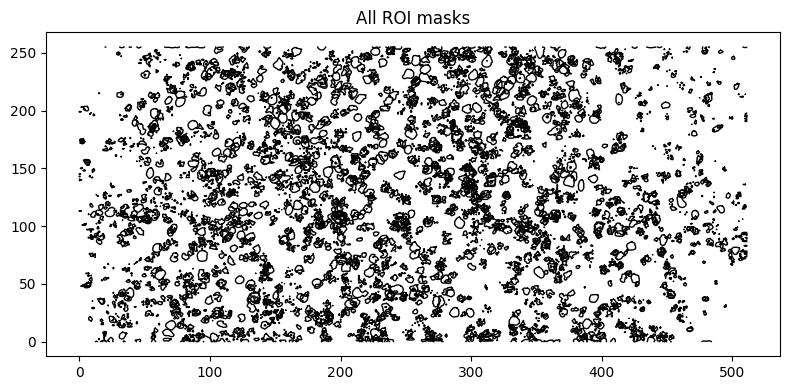

In [102]:
# Figure parameters for vertically stacked plots 
fig, ax = plt.subplots(figsize=(8, 4))

# Plot ROI contours 
for i, mask in enumerate(roi_table.image_mask):
    mask_array = np.array(mask)
    # Find contours at a level that works well for binary masks
    contours = measure.find_contours(mask_array, level=0.5)
    
    for contour in contours:
        color = 'k'
        linewidth = 1.0
        # Plot contour (note: contour coordinates are in (row, col) format)
        ax.plot(contour[:, 1], contour[:, 0], color=color, linewidth=linewidth)
        
# Label
ax.set_title('All ROI masks')

plt.tight_layout()
plt.show()

Those dont all look like cell somas..

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
We can use the `soma_probability` column of the `roi_table` to filter out ROIs that are not cell somas. 
    
We also saw earlier that some of the traces are NaNs (white rows in heatmap of traces) - lets remove these too. 

</div>

In [103]:
# Remove ROIs with traces that are NaNs (note - this takes a few seconds)
valid_trace_ids = [i for i in range(dff_traces.shape[1]) if np.isnan(dff_traces[0, i])==False]
# Limit ROI table to non-NaN traces
roi_table = roi_table.loc[valid_trace_ids]

In [104]:
# Find the likely somatic ROIs
soma_probability = 0.005 # Emperically determined threshold - just trust us
# Limit to valid somatic ROIs
valid_rois = roi_table[roi_table.soma_probability>soma_probability]
print('there are', len(valid_rois), 'ROIs with soma_probability >',soma_probability)

there are 226 ROIs with soma_probability > 0.005


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

Let's check that our `soma_probability` threshold is capturing most of the cell soma ROIs and removing most of the junk ROIs. 
    
Plot the valid ROI outlines overlaid on the average image of the field of view. 

</div>

In [105]:
# First load our average image
average_image = nwbfile.processing["processed"].data_interfaces["images"].images["average_projection"].data[:] 
average_image.shape

(256, 512)

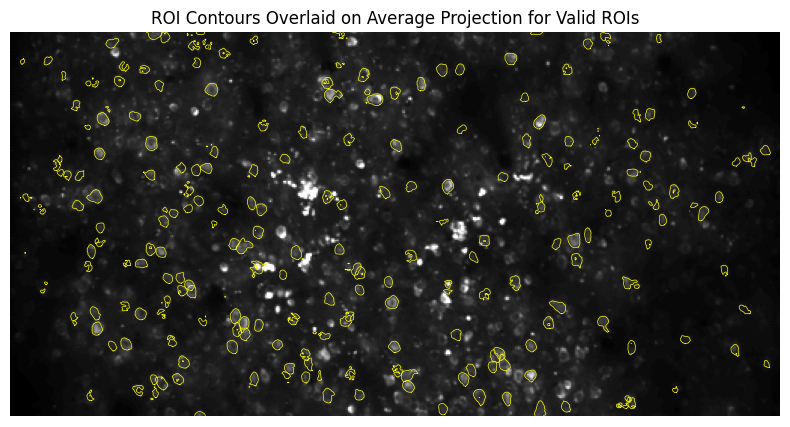

In [106]:
# Plot ROI contours overlayed on average image 
fig, ax = plt.subplots(figsize=(8, 6))

# First plot average image
ax.imshow(average_image, cmap='gray', origin='upper', aspect='equal', vmax=0.25)
ax.set_title('ROI Contours Overlaid on Average Projection for Valid ROIs')
ax.axis('off')

# Overlay ROI contours
for i, mask in enumerate(valid_rois.image_mask):
    mask_array = np.array(mask)
    # Find contours at a level that works well for binary masks
    contours = measure.find_contours(mask_array, level=0.5)
    
    for contour in contours:
        color = 'yellow'
        linewidth = 0.5
        
        # Plot contour (note: contour coordinates are in (row, col) format)
        ax.plot(contour[:, 1], contour[:, 0], color=color, linewidth=linewidth)
        
# Set the axis limits to match the image dimensions
ax.set_xlim(0, average_image.shape[1])
ax.set_ylim(average_image.shape[0], 0)  # Flip y-axis to match image coordinates

plt.tight_layout()
plt.show()

This looks much more reasonable. 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Limit spontaneous pre and post dff traces to valid ROIs
    
The index of the `roi_table` is the ROI ID. 

The valid ROI IDs correspond to the indices of the `dff_pre` and `dff_post` arrays we created earlier (recall that we transposed them so that the ROI IDs were the rows and the 2P frames were columns).

</div>

In [107]:
# Check the shape of our dff traces array - the longer axis is 2P frames, the shorter one is ROIs
dff_pre.shape

(1736, 13799)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

Use the valid ROI IDs to index into `dff_pre` and `dff_post` to limit to valid somatic ROI IDs. 

</div>

In [108]:
# Limit dff traces for spontaneous activity period before the task to valid ROIs
dff_pre = dff_pre[valid_rois.index.values, :]
print(dff_pre.shape)

(226, 13799)


In [109]:
# Limit dff traces for spontaneous activity period before the task to valid ROIs
dff_post = dff_post[valid_rois.index.values, :]
print(dff_pre.shape)

(226, 13799)


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** Visualize the fildered dFF traces for each spontaneous period as a heatmap. Label your axes.
    
Hint: use [pcolormesh](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolormesh.html) to plot, it makes nicer heatmaps than imshow and interprets the axes nicely (but takes a bit longer).

</div>

Note that the white lines in the heatmap are gone - those were invalid ROIs! Now they are gone and we can do our analysis

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Quantifying correlations
    
Correlations between neuron activity traces could indicate a direct connection between them or that they receive shared input and are part of an interacting network. Let's compute the pairwise correlations between all the neurons and compare them for pre and post spontaneous periods. 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

Quantify the correlation between every cell pair's dff traces for the pre and post spontaneous periods using [np.corrcoef](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html). 
    
We will save the output to two variables called `correlations_pre` and `correlations_post` so we can use them later in our analysis.


In [110]:
correlations_pre = np.corrcoef(dff_pre)
correlations_post = np.corrcoef(dff_post)

correlations_pre.shape

(226, 226)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** Plot the matrix of correlations each as a heatmap. 
    
Dont forget to label your axes and include a title so you remember which is pre and which is post. 
    
Did the correlations change?

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
To quantify differences in the distribution of pairwise correlation values, we only want to count each pair once and we dont want to include each cell's correlation to itself (which is always 1, along the diagonal). 

To remove the diagonal and the duplicates in the matrix, we can use [np.triu()](https://numpy.org/doc/2.1/reference/generated/numpy.triu.html) with k=1. 



In [111]:
correlations_pre = np.triu(correlations_pre, k=1)
correlations_post = np.triu(correlations_post, k=1)

(np.float64(0.0), np.float64(226.0), np.float64(0.0), np.float64(226.0))

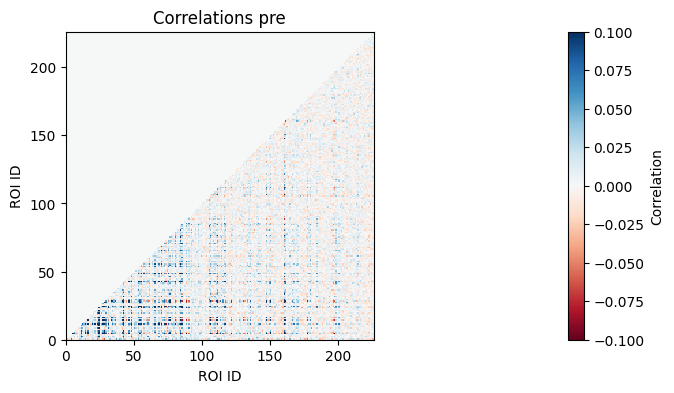

In [112]:
plt.pcolormesh(correlations_pre, cmap='RdBu', vmin=-0.1, vmax=0.1)
plt.colorbar(label='Correlation')
plt.xlabel('ROI ID')
plt.ylabel('ROI ID')
plt.title('Correlations pre')
plt.axis('square')

(np.float64(0.0), np.float64(226.0), np.float64(0.0), np.float64(226.0))

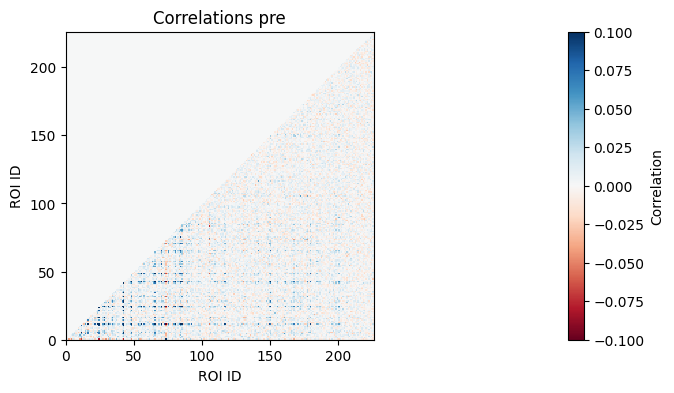

In [113]:
plt.pcolormesh(correlations_post, cmap='RdBu', vmin=-0.1, vmax=0.1)
plt.colorbar(label='Correlation')
plt.xlabel('ROI ID')
plt.ylabel('ROI ID')
plt.title('Correlations pre')
plt.axis('square')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** Check for statistical differences in the distribution of pairwise correlations.
    
Hint: Flatten the matrix of correlations into a 1D array then 
do a t-test with [scipy.stats.ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)

Are the distributions statistically different? 

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

Plot the distribution of correlation values for spontaneous pre and spontaneous post. Include the p-value in the plot title
    
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Part 4: Do correlations depend on distance between neurons?</h2>
    - Segmented ROI masks and spatial relationships


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

If cells that are closer in space are more likely to be connected, they could also be more likely to be correlated. 
    
To compute distances between cells and compare them to the correlation values, we need to use the `roi_table` to get the locations of the ROIs.
    
Note that we only want to look at our `valid_rois`, which are the ones we computed correlations for.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Calculate the centroid location for each ROI image mask and compute distances

The ROI image masks are represented as a HxW sparse array with non-zero values that span the ROI area. We can find the centroid of the ROI by calculating the mean of the x,y indices of each mask. We've pre-written the function `get_roi_centroids` to do this. 

In [114]:
def get_roi_centroids(roi_table):
    '''
    Iterate through the image masks in the ROI table, 
    get the indices corresponding to each ROI, 
    then take the average to get the x and y locations of the cell centroid. 
    
    Returns an array with dimensions (n_cells, xy_position)
    '''
    centroids = []
    for mask in roi_table['image_mask']:
        ys, xs = np.where(mask)
        x = np.mean(xs)
        y = np.mean(ys)
        centroids.append((x, y))
    return np.array(centroids)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** Use the provided function to get the centroid locations for ROIs in the `valid_rois` table. 
    
Save the output to a variable called `centroids`. Plot the centroid locations as a scatterplot. 
    
Hint: Pay attention to the shape of the array produced by the function. Which dimension corresponds to ROIs and which corresponds to x and y location? 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Calculate distances between ROI centroids and relate to spontaneous activity correlations. 

First let's calculate the distance between one pair of cells using [math.dist](https://docs.python.org/3/library/math.html#math.dist)


In [115]:
import math

In [116]:
centroid_cell_1 = centroids[0, :]
centroid_cell_2 = centroids[1, :]

math.dist(centroid_cell_1, centroid_cell_2)

284.7976594244874

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now we can iterate through all pairs and build up a pandas table with the following information: 
* the centroid location of each cell in the pair
* the distance between the centroids
* the spontaneous activity correlations for that pair before and after the BCI task 
* the difference between correlations pre and post for each cell pair
    
Note - you will need to have saved the correlations to two variables called `correlations_pre` and `correlations_post` as instructed in a prior step for this to work!

In [117]:
pairs_data = []
for roi_id_1 in range(len(valid_rois.index.values)): 
    for roi_id_2 in range(len(valid_rois.index.values)): 
        centroid_cell_1 = centroids[roi_id_1, :]
        centroid_cell_2 = centroids[roi_id_2, :]
        distance = math.dist(centroid_cell_1, centroid_cell_2)
        r_value_pre = correlations_pre[roi_id_1, roi_id_2]
        r_value_post = correlations_post[roi_id_1, roi_id_2]
        r_value_diff = r_value_post-r_value_pre
        pairs_data.append([roi_id_1, roi_id_2, r_value_pre, r_value_post, r_value_diff, distance])


In [118]:
pairs = pd.DataFrame(pairs_data, columns=['roi_id_1', 'roi_id_2', 'r_value_pre', 'r_value_post', 'r_value_diff', 'distance'])
pairs.head()

,roi_id_1,roi_id_2,r_value_pre,r_value_post,r_value_diff,distance
0,0,0,0.000000,0.000000,0.000000,0.000000
1,0,1,0.026703,0.009220,-0.017483,284.797659
2,0,2,-0.017990,-0.040539,-0.022549,148.892587
3,0,3,-0.000963,-0.018297,-0.017334,215.836630
4,0,4,-0.065450,-0.045344,0.020106,169.016107


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** Plot the relationship between ROI distance and spontaneous activity correlations before and after the BCI task

Include `r_value_pre` and `r_value_post` in different colors on the same plot.

Is there a relationship? 

#### What other factors could influence how correlated neurons are during different epochs? 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; ">

### Questions and analyses to explore further:
 
* Which neuron pairs have the largest changes in correlations after BCI learning? Do they increase or decrease? Are they also correlated to the conditioned neuron? Get the conditioned neuron ID from the BCI trials table and compare it's activity to  other cells in the population. 
   
* Do correlated neurons tend to have stronger connections? Use the photostimulation periods to measure connection strength across neurons based on their response latency and relate to spontaneous activity correlations.
    
* How does the activity of the conditioned neuron change throughout the BCI task? Quantify it's mean activity across trials in the behavior block. How does the activity relate to the animal's behavior? 
        
* Do non-conditioned neurons change their activity during the BCI task? Were these cells more highly connected to the conditioned neuron prior to BCI learning? 
    
<b>* How do spontaneous activity correlations in this dataset compare to other available datasets? Do correlations depend on cell type, brain area, or cortical depth? </b>
    